# RPN Regional Proposal Network

Una RPN, es una red neuronal orientada a extraer proposals **de un feature map** , al contrario que Selective Search, no las extrae de las imagenes si no directamente del mapa de características. Por lo que nos permite deshacernos de SS y su bottleneck, para obtener directamente propuestas del mapa de caracteristicas de cada imagen.

- La RPN consume feature maps, no imágenes crudas
- Queremos obtener (C, H, W) y el stride efectivo del backbone para imagenes en VOC

Empecemos por los imports y la configuración inicial

## 1 Configuración DS Backbone y Feature Extraction

In [126]:
import os, random, math, time, pathlib, shutil, json
import numpy as np
import torch
import torchvision as tv
import selectivesearch
from torchvision.models import ResNet50_Weights
from torchsummary import summary
from torchvision.datasets import VOCDetection
from torchvision.transforms.functional import to_tensor, normalize
from pathlib import Path
import pickle
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torch import nn
from torchsummary import summary

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("CUDA disponible:", torch.cuda.is_available())
print("Device:", device)

if device.type == "cuda":

    torch.backends.cuda.matmul.fp32_precision = "tf32"     
    torch.backends.cudnn.conv.fp32_precision = "tf32"     

    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

VOC_ROOT = os.environ.get("VOC_ROOT", "./data/02")
print("VOC_ROOT:", VOC_ROOT)

#Importamos el modelo de ResNet50
weights = ResNet50_Weights.IMAGENET1K_V2
resnet_transforms = weights.transforms()



#VOC 2007
train_root = "./data/02/VOCtrainval_06-Nov-2007"
test_root  = "./data/02/VOCtest_06-Nov-2007"

train_ds = VOCDetection(train_root, year="2007", image_set="trainval", download=False)
test_ds  = VOCDetection(test_root,  year="2007", image_set="test",     download=False)

print("Train:", len(train_ds))
print("Test:", len(test_ds))

CUDA disponible: True
Device: cuda
VOC_ROOT: ./data/02
Train: 5011
Test: 4952


Preprocesaremos Imagenes de VOC igual que hicimos en FastRCNN, pero, no trabajaremos las bboxes ni las escalaremos.
Solo queremos cargar una imagen, redimensionarla y normalizarla para extraer features del backbone.

En RPN la logica es:

- Backbone → feature map

- Feature map → anchors

- Luego se comparan anchors con GT boxes originales o escaladas, pero eso ocurre en otro sitio
(no en el preprocesado de imagen).

In [127]:
from PIL import Image
from torchvision.datasets import VOCDetection
from torchvision.transforms.functional import to_tensor, normalize

# Parámetros de escalado
short_side = 600
max_side = 1000

# Normalización para ResNet (usa tu propio resnet_transforms)
R50_MEAN = resnet_transforms.mean
R50_STD  = resnet_transforms.std

def preprocess_image(img, device=device, short_side=short_side, max_side=max_side):
    # Tamaño original
    w, h = img.size
    orig_size = (h, w)  # (H,W)

    # Escalado igual que en Fast R-CNN
    actual_short = min(w, h)
    actual_long  = max(w, h)

    scale = short_side / actual_short
    if actual_long * scale > max_side:
        scale = max_side / actual_long

    new_w = int(w * scale)
    new_h = int(h * scale)

    new_size = (new_h, new_w)
    img_resized = img.resize((new_w, new_h), Image.BILINEAR)

    #Convertimos a tensor y normalizamos
    img_t = to_tensor(img_resized)
    img_t = normalize(img_t, R50_MEAN, R50_STD)
    img_t = img_t.unsqueeze(0).to(device)  # [1,3,H,W]

    #Devolvemos el tensor, el tamaño original, el nuevo tamaño y el factor de escala
    return img_t, orig_size,  new_size, scale, img_resized


#Cargamos una imagen de VOC
def load_image_voc(dataset, idx):
    sample = dataset[idx]
    pil_img = sample["image"] if "image" in sample else sample[0]  

    img_t, orig_size, new_size, scale, img_resized = preprocess_image(pil_img)
    return img_t, orig_size, new_size, scale, img_resized

    #img_t: tensor imagen redimensionada y normalizada
    #orig_size: tamaño original de la imagen (H,W)
    #new_size: tamaño nuevo de la imagen (H,W)
    #scale: factor de escala 
    #img_resized: imagen redimensionada (PIL)


Ahora, cargaremos el backbone de Resnet50, cortaremos el head, lo pondremos en eval y congelaremos.

In [128]:
#Importamos el modelo de ResNet50
backbone = nn.Sequential(*list(models.resnet50(weights=weights).children())).to(device)

#En el notebook anterior vimos como calcular el stride 16 (acumulado) y que estaba en el layer 7.
BACKBONE_CUT = 7
BACKBONE_STRIDE = 16

backbone = nn.Sequential(*list(models.resnet50(weights=weights).children())[:BACKBONE_CUT]).to(device)

#Congelamos el backbone
backbone.eval()
for p in backbone.parameters():
    p.requires_grad = False



Crearemos ahora una funcion para extraer features de cada imagen.

-Notesé que nuestro stride es fijo (BACKBONE_STRIDE = 16) y que lo devolvemos en extract_features, realmente no seria necesario devolverlo en este caso.

Pero lo hacemos porque en arquitecturas más avanzadas como **FPN (Feature Pyramid Netowks)** que son derivadas de RPN, el stride cambia ya que, en ese caso no solo operamos a nivel de una capa (C4) si no de otras más pequeñas, eso ayudará a que, al extraer features a distintos niveles de stride con features maps de distinto tamaño, podamos detectar despues propuestas más pequeñas.

Sin embargo, de momento, lo dejamos como BACKBONE_STRIDE = 16 y lo devolvemos para hacer un guiño a los siguientes capitulos, ya veremos como lo hacemos en otro notebook.

Para aclarar:

Lo que hace una RPN clásica es lo siguiente:

    -Se pasa la imagen por el backbone ResNet-50 hasta el bloque C4.

    -La salida es un feature map de tamaño [1024, Hf, Wf] y stride ≈16 respecto a la imagen procesada.

    Ese feature map es la entrada única de la RPN:

        -para colocar anchors centrados en cada celda del grid,

        -para predecir objectness y shifts de caja,

        -para generar propuestas (ROIs) para Fast R-CNN.

In [129]:
#Funcion para extraer features del backbone
def extract_features(img_t):

    feat_map = backbone(img_t)

    return feat_map, BACKBONE_STRIDE



#Cargamos una imagen de VOC
img_t, orig_size, new_size, scale, img_resized = load_image_voc(train_ds, 0)

#Extraemos features del backbone
feat_map, stride = extract_features(img_t)

#Imprimimos el shape del feature map y el stride
print(feat_map.shape, stride)






torch.Size([1, 1024, 38, 50]) 16


## 2. Anchors base y grid sobre el feature map (C4, stride=16)

En RPN no tenemos selective search que nos daba ya las propuestas, por lo que tenemos que definirlas nosotros.

#### Anchors

En RPNs, los anchors son la definición de nuestras propuestas, y estan compuestos por:

[x1,y1,x2,y2] en papers suelen definirse como [centroide, w, h]

En general se definen como scale y aspect ratio.

scale = son areas de las propuestas (tamaño)

ratio = son las proporciones de las propuestas Ratio = ancho / alto.

Combinando scales y ratios generamos anchors de:

- distintos tamaños
- diferentes formas
- orientados horizontal o vertical

Para scale=256:

| ratio | forma      | w x h aproximado        | área aproximada |
|-------|------------|--------------------------|------------------|
| 1     | cuadrado   | 256 × 256                | 65536            |
| 0.5   | vertical   | 181 × 362                | 65522            |
| 2     | horizontal | 362 × 181                | 65522            |


Definimos SCALES, RATIOS y el valor K, que representa el número total de anchors distintos generados por las combinaciones de escalas y ratios (anchors por celda del feature map).

- SCALES → tamaños base de los anchors (aproximadamente la raíz del área por lo que el area w * h es = al cuadrado de scale)

w * h = scale²


- RATIOS → relación ancho/alto de cada anchor

w / h = ratio

- K → número total de combinaciones scale × ratio
(es decir, el número de anchors diferentes por cada celda del feature map)



In [130]:

ANCHOR_SCALES = [128, 256, 512]
ANCHOR_RATIOS = [0.5, 1.0, 2.0]

K = len(ANCHOR_SCALES) * len(ANCHOR_RATIOS)


print(f"K = {K} = {len(ANCHOR_SCALES)} * {len(ANCHOR_RATIOS)}")

K = 9 = 3 * 3


### Cálculo de w y h para cada anchor base

Dado un `scale` y un `ratio`, queremos definir las dimensiones `(w, h)` del anchor de forma que:

- 1) El área quede fija: `w * h = scale²`
- 2) La forma venga dada por el ratio: `ratio = w / h`

Necesitamos que se cumplan las dos porque queremos 1) el MISMO area siempre 2) para cualquier forma.

Esto nos deja un sistema de ecuaciones:

[`w * h = scale²` , `ratio = w / h` ]


Así que empezamos a despejarlo:

De `ratio = w / h` podemos escribir:

- `w = ratio * h`

y ya tendríamos w definido, sin embargo con h:

---

### 1. Despejar h

Partimos de:

- `w = ratio * h`
- `w * h = scale²`

Sustituimos `w` en la ecuación del área:

- `(ratio * h) * h = scale²`
- `ratio * h² = scale²`

Despejamos `h²`:

- `h² = scale² / ratio`

Para quitar el cuadrado aplicamos raíz cuadrada en ambos lados:

- `h = sqrt(scale² / ratio)`

Usamos la propiedad `sqrt(A/B) = sqrt(A) / sqrt(B)`:

- `h = sqrt(scale²) / sqrt(ratio)`

Y como `sqrt(scale²) = scale`:

- `h = scale / sqrt(ratio)`

Es decir:

- `h = scale / sqrt(ratio)`

---

### 2. Calcular w a partir de h

Sabemos que:

- `w = ratio * h`

Sustituimos `h`:

- `w = ratio * (scale / sqrt(ratio))`
- `w = scale * (ratio / sqrt(ratio))`

Ahora usamos que:

- `ratio = sqrt(ratio) * sqrt(ratio)`

Entonces:

- `w = scale * (sqrt(ratio) * sqrt(ratio) / sqrt(ratio))`

Podemos simplificar porque:

- `(sqrt(ratio) * sqrt(ratio)) / sqrt(ratio) = sqrt(ratio)`

Nos queda:

- `w = scale * sqrt(ratio)`

---

### 3. Resultado final

Para cada par `(scale, ratio)`:

- `w = scale * sqrt(ratio)`
- `h = scale / sqrt(ratio)`

---

### 4. Construcción del anchor [x1, y1, x2, y2] centrado en (0,0)

Una vez tenemos `w` y `h`, definimos el anchor base centrado en el origen:

- `x1 = -w / 2`
- `y1 = -h / 2`
- `x2 =  w / 2`
- `y2 =  h / 2`

Cada combinación `(scale, ratio)` produce un anchor `[x1, y1, x2, y2]`.

Si tenemos:

- `len(SCALES) * len(RATIOS) = K`

entonces tendremos un tensor de anchors base de tamaño:

- `[K, 4]` donde cada fila es `[x1, y1, x2, y2]`.


In [131]:
def generate_base_anchors(scales, ratios):
    anchors = []
    for scale in scales:
        for ratio in ratios:

            #Estas funciones se calculan en la descripcion del punto anterior
            w = scale * np.sqrt(ratio)
            h = scale / np.sqrt(ratio)

            #Aqui generamos los anchors base centrado en el origen, por eso usamos negativos
            x1 = -w / 2
            y1 = -h / 2
            x2 =  w / 2
            y2 =  h / 2
            
            anchors.append([x1, y1, x2, y2])

            

    return torch.tensor(anchors, dtype=torch.float32)

base_anchors = generate_base_anchors(ANCHOR_SCALES, ANCHOR_RATIOS)
print(base_anchors.shape)
len(base_anchors)






torch.Size([9, 4])


9

Vamos a visualizar nuestros anchors base:

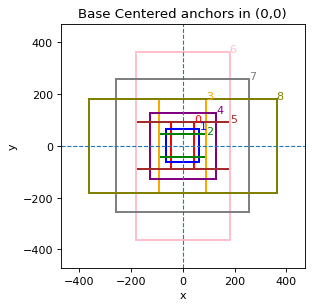

In [137]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

base_anchors = generate_base_anchors(ANCHOR_SCALES, ANCHOR_RATIOS)

# valores mínimos y máximos
xmin = float(base_anchors[:,0].min())
ymin = float(base_anchors[:,1].min())
xmax = float(base_anchors[:,2].max())
ymax = float(base_anchors[:,3].max())

# margen adicional
margin = max(xmax - xmin, ymax - ymin) * 0.15

fig, ax = plt.subplots(figsize=(4, 4), dpi=80)

colors = ['red','blue','green','orange','purple','brown','pink','gray','olive']

for i, (x1, y1, x2, y2) in enumerate(base_anchors):
    w = x2 - x1
    h = y2 - y1
    color = colors[i % len(colors)]
    rect = patches.Rectangle((x1, y1), w, h, fill=False, color=color, linewidth=1.8)
    ax.add_patch(rect)
    ax.text(x2, y2, f"{i}", fontsize=10, color=color)

ax.axhline(0, linestyle='--', linewidth=1)
ax.axvline(0, linestyle='--', linewidth=1)

ax.set_aspect('equal', 'box')
ax.set_xlim(xmin - margin, xmax + margin)
ax.set_ylim(ymin - margin, ymax + margin)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Base Centered anchors in (0,0)")

plt.tight_layout()
plt.show()
plt.close(fig)


Ahora lo que necesitamos es generar estos anchors sobre un grid con stride 16

In [ ]:
#Primero cargamos una imagen de VOC, extraemos las features del backbone

img_t, orig_size, new_size, scale, img_resized = load_image_voc(train_ds, 0)

feat_map, stride = extract_features(img_t)

#Ahora extraemos el shape del feature map y nos quedamos con H y W que son las dimensiones del grid
Hf, Wf = feat_map.shape[-2], feat_map.shape[-1]

#Ademas obtenemos el stride predefinido en el backbone
print("feat_map:", feat_map.shape, "Hf =", Hf, "Wf =", Wf, "stride =", stride)

def generate_anchors_on_grid(base_anchors, feat_h, feat_w, stride, device=None):
    if device is None:
        device = base_anchors.device

    base_anchors = base_anchors.to(device)

    #Posiciones X de las celdas del grid, usamos arange para generar un array de 0 a feat_w-1
    #Multiplicamos por stride para que coincida con el stride del feature map
    shift_x = torch.arange(feat_w, device=device) * stride


    #Posiciones Y de las celdas del grid, usamos arange para generar un array de 0 a feat_h-1
    #Multiplicamos por stride para que coincida con el stride del feature map
    shift_y = torch.arange(feat_h, device=device) * stride
  
    #Generamos las posiciones X y Y del grid, usamos meshgrid para que sean coordenadas cartesianas
    #Lo que hace meshgrid es generar todas las combinaciones de shift_x y shift_y para cada posicion del grid
    shift_y, shift_x = torch.meshgrid(shift_y, shift_x, indexing="ij")

    #Creamos un tensor con las coordenadas de las celdas del grid y las stackamos para poder sumarlas a los anchors base
    shifts = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=-1)
 
    #Ahora tenemos un tensor de shape (Hf * Wf, 4) con las coordenadas de las celdas del grid
    shifts = shifts.reshape(-1, 4)
 
    A = base_anchors.shape[0]
    K = shifts.shape[0]
    print("A:", A)
    print("K:", K)

    #Ahora generamos los anchors desplazados por las coordenadas del grid
    anchors = base_anchors.view(1, A, 4) + shifts.view(K, 1, 4)
    anchors = anchors.view(K * A, 4)

    return anchors

all_anchors = generate_anchors_on_grid(base_anchors, Hf, Wf, BACKBONE_STRIDE, device=device)


feat_map: torch.Size([1, 1024, 38, 50]) Hf = 38 Wf = 50 stride = 16
shift_x: tensor([  0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432,
        448, 464, 480, 496, 512, 528, 544, 560, 576, 592, 608, 624, 640, 656,
        672, 688, 704, 720, 736, 752, 768, 784], device='cuda:0')
shift_x shape: torch.Size([50])
shift_y: tensor([  0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432,
        448, 464, 480, 496, 512, 528, 544, 560, 576, 592], device='cuda:0')
shift_y shape: torch.Size([38])
shift_y: tensor([[  0,   0,   0,  ...,   0,   0,   0],
        [ 16,  16,  16,  ...,  16,  16,  16],
        [ 32,  32,  32,  ...,  32,  32,  32],
        ...,
        [560, 560, 560,  ..., 560, 560, 560],
        [576, 576, 576,  ..., 576, 576, 576],
        [592, 592, 592,  ..., 592, 592, 592]], device='cuda:0')
sh